In [1]:
import sys

sys.path.append("../")


In [2]:
import os
import warnings
import argparse

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import random

warnings.filterwarnings("ignore")

from copy import deepcopy
from exp import utils_cv
from utils.print_args import print_args
torch.set_float32_matmul_precision('high')

In [3]:
def fix_seeds(seed_value: int = 42, device: str = "cpu") -> None:
    """Source 'https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5'.

    :param seed_value: random state value
    :param device: device for which seeds would be fixed
    """
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != "cpu":
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [4]:
slice_len = 100
well_column = "WELLNAME"

In [5]:
save_dir = "./save_transformer_cab/"
log_dir = "./log_transformer_cab/"

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

if not os.path.exists(log_dir):
    os.mkdir(log_dir)

In [6]:
def get_dict(res_dict, model_name):
    metrics = dict()

    for d in res_dict:
        f1_flag = False
        for k, v in d.items():
            v = np.array(v)
            v[v == -1000000.0] = np.nan
            if not f1_flag and "Precision" in k:
                precision = deepcopy(v)
                predicate = "" if "_" not in k else k.split("_")[0] + "_"
            if not f1_flag and 'Recall' in k:
                recall = deepcopy(v)
                metrics["{}F1".format(predicate)] = [calc_f1_score(precision, recall)]
                f1_flag = True

            metrics[k] = ['{} ± {}'.format(
                round(v.mean(), 3), 
                round(v.std(), 3)
            )]
    return pd.DataFrame(metrics, index=[model_name]) 

In [7]:
parser = argparse.ArgumentParser(description='TimesNet')

# basic config
parser.add_argument('--task_name', type=str, required=False, default='imputation',
                    help='task name, options:[long_term_forecast, short_term_forecast, imputation, classification, anomaly_detection]')
parser.add_argument('--is_training', type=int, required=False, default=1, help='status')
parser.add_argument('--model_id', type=str, required=False, default='test', help='model id')
parser.add_argument('--model', type=str, required=False, default='TransformerCAB',
                    help='model name, options: [Autoformer, Transformer, TimesNet]')

# data loader
parser.add_argument('--data', type=str, required=False, default='ETTh1', help='dataset type')
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')
parser.add_argument('--seasonal_patterns', type=str, default='Monthly', help='subset for M4')
parser.add_argument('--inverse', action='store_true', help='inverse output data', default=False)

# inputation task
parser.add_argument('--mask_rate', type=float, default=0.25, help='mask ratio')

# anomaly detection task
parser.add_argument('--anomaly_ratio', type=float, default=0.25, help='prior anomaly ratio (%)')

# model define
parser.add_argument('--expand', type=int, default=2, help='expansion factor for Mamba')
parser.add_argument('--d_conv', type=int, default=4, help='conv kernel size for Mamba')
parser.add_argument('--top_k', type=int, default=5, help='for TimesBlock')
parser.add_argument('--num_kernels', type=int, default=6, help='for Inception')
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.1, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser.add_argument('--channel_independence', type=int, default=1,
                    help='0: channel dependence 1: channel independence for FreTS model')
parser.add_argument('--decomp_method', type=str, default='moving_avg',
                    help='method of series decompsition, only support moving_avg or dft_decomp')
parser.add_argument('--use_norm', type=int, default=1, help='whether to use normalize; True 1 False 0')
parser.add_argument('--down_sampling_layers', type=int, default=0, help='num of down sampling layers')
parser.add_argument('--down_sampling_window', type=int, default=1, help='down sampling window size')
parser.add_argument('--down_sampling_method', type=str, default=None,
                    help='down sampling method, only support avg, max, conv')
parser.add_argument('--seg_len', type=int, default=48,
                    help='the length of segmen-wise iteration of SegRNN')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
parser.add_argument('--itr', type=int, default=1, help='experiments times')
parser.add_argument('--epochs', type=int, default=10, help='train epochs')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='MSE', help='loss function')
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')


# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')


# de-stationary projector params
parser.add_argument('--p_hidden_dims', type=int, nargs='+', default=[128, 128],
                    help='hidden layer dimensions of projector (List)')
parser.add_argument('--p_hidden_layers', type=int, default=2, help='number of hidden layers in projector')

# metrics (dtw)
parser.add_argument('--use_dtw', type=bool, default=False, 
                    help='the controller of using dtw metric (dtw is time consuming, not suggested unless necessary)')

# Augmentation
parser.add_argument('--augmentation_ratio', type=int, default=0, help="How many times to augment")
parser.add_argument('--seed', type=int, default=2, help="Randomization seed")
parser.add_argument('--jitter', default=False, action="store_true", help="Jitter preset augmentation")
parser.add_argument('--scaling', default=False, action="store_true", help="Scaling preset augmentation")
parser.add_argument('--permutation', default=False, action="store_true", help="Equal Length Permutation preset augmentation")
parser.add_argument('--randompermutation', default=False, action="store_true", help="Random Length Permutation preset augmentation")
parser.add_argument('--magwarp', default=False, action="store_true", help="Magnitude warp preset augmentation")
parser.add_argument('--timewarp', default=False, action="store_true", help="Time warp preset augmentation")
parser.add_argument('--windowslice', default=False, action="store_true", help="Window slice preset augmentation")
parser.add_argument('--windowwarp', default=False, action="store_true", help="Window warp preset augmentation")
parser.add_argument('--rotation', default=False, action="store_true", help="Rotation preset augmentation")
parser.add_argument('--spawner', default=False, action="store_true", help="SPAWNER preset augmentation")
parser.add_argument('--dtwwarp', default=False, action="store_true", help="DTW warp preset augmentation")
parser.add_argument('--shapedtwwarp', default=False, action="store_true", help="Shape DTW warp preset augmentation")
parser.add_argument('--wdba', default=False, action="store_true", help="Weighted DBA preset augmentation")
parser.add_argument('--discdtw', default=False, action="store_true", help="Discrimitive DTW warp preset augmentation")
parser.add_argument('--discsdtw', default=False, action="store_true", help="Discrimitive shapeDTW warp preset augmentation")
parser.add_argument('--extra_tag', type=str, default="", help="Anything extra")

parser.add_argument('--corr_beta', type=float, default='0.0',help='corr_beta')
parser.add_argument('--corr_lambda', type=float, default='0.0',help='corr_lambda')
parser.add_argument('--corr_tau', type=float, default='1.0',help='corr_tau')
parser.add_argument('--corr_factor', type=int, default='1',help='corr_factor')
parser.add_argument('--n_corr_heads', type=int, default=0, help='num of corr heads')

# parser.add_argument('--n_warmup', type=int, default=5, help='num of warmup steps')
# parser.add_argument('--sch_gamma', type=float, default='0.94',help='scheduler gamma')
# parser.add_argument('--sch_start_factor', type=float, default='0.21',help='scheduler start factor')


parser.add_argument('--save_dir', type=str, default='./save_transformer_cab/',help='save dir')
parser.add_argument('--log_dir', type=str, default='./log_transformer_cab/',help='log dir')


parser.add_argument('-f', type=str, default='None')

args = parser.parse_args()


print('Args in experiment:')
print_args(args)



Args in experiment:
Basic Config
  Task Name:          imputation          Is Training:        1                   
  Model ID:           test                Model:              TransformerCAB      

Data Loader
  Data:               ETTh1               Root Path:          ./data/ETT/         
  Data Path:          ETTh1.csv           Features:           M                   
  Target:             OT                  Freq:               h                   
  Checkpoints:        ./checkpoints/      

Imputation Task
  Mask Rate:          0.25                

Model Parameters
  Top k:              5                   Num Kernels:        6                   
  Enc In:             7                   Dec In:             7                   
  C Out:              7                   d model:            512                 
  n heads:            8                   e layers:           2                   
  d layers:           1                   d FF:               2048                
  M

In [8]:
for device_id in range(torch.cuda.device_count()):
    fix_seeds(device=f'cuda:{device_id}')


In [9]:
specific_params_dropdim = {
    
    
    "d_ff" : ("int", [256, 1024, 64]),
    "e_layers": ("int", [2, 8, 1]),
    
    "sch_start_factor": ("float", [0.01, 0.33]),
    "sch_gamma": ("float", [0.8, 0.99]),
    "n_warmup": ("int", [0, 5, 1]),
    "learning_rate": ("float", [1e-4, 1e-3]),
    

    "factor": ("cat", [1, 2, 3]),                  #NEW
    
}


# Reguformer with Correlation Attention

In [10]:
n_trials = 1

res_model, results, mse_all_trials = utils_cv.optuna_hpo_and_best_model_evaluation(
    n_trials=n_trials,
    specific_params=specific_params_dropdim,
    args=args,
) 
np.save(
    os.path.join(args.save_dir, "mse_transforemr-cab.npy"),
    mse_all_trials,
)
torch.save(
    res_model.state_dict(), 
    os.path.join(
        args.save_dir, 'res_transforemr-cab.pth'
    ),
)
ans_df = pd.DataFrame(results, index=["transforemr-cab"])

ans_df.to_csv(
    os.path.join(
        args.save_dir, "res_df_transforemr-cab.csv"
    )
)

model_type: TransformerCAB


[I 2024-05-25 23:57:17,588] A new study created in RDB with name: no-name-c2708015-662a-4789-94c7-6dec7f1137f7


sch_start_factor [0.01, 0.33]
sch_gamma [0.8, 0.99]
learning_rate [0.0001, 0.001]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log_transformer_cab/TransformerCAB_05252024_23_57_18
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type    | Params
------------------------------------------
0 | model         | Model   | 10.5 M
1 | loss_function | MSELoss | 0     
------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params
42.175    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

val 2785
train 8449


Training: |                                                                                                   …

Validation: |                                                                                                 …

Metric val_loss improved. New best score: 0.211


Validation: |                                                                                                 …

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.198


Validation: |                                                                                                 …

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.196


Validation: |                                                                                                 …

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.193


Validation: |                                                                                                 …

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.192


Validation: |                                                                                                 …

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.192


Validation: |                                                                                                 …

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.190


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.188
`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-25 23:58:28,150] Trial 0 finished with value: 0.18760980665683746 and parameters: {'d_ff': 2048, 'e_layers': 2, 'sch_start_factor': 0.2553530982166787, 'sch_gamma': 0.9745257557995113, 'n_warmup': 0, 'learning_rate': 0.0001, 'factor': 1}. Best is trial 0 with value: 0.18760980665683746.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log_transformer_cab/TransformerCAB_05252024_23_58_28
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type    | Params
------------------------------------------
0 | model         | Model   | 10.5 M
1 | loss_function | MSELoss | 0     
------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params
42.175    Total estimated 

best_params: {'d_ff': 2048, 'e_layers': 2, 'sch_start_factor': 0.2553530982166787, 'sch_gamma': 0.9745257557995113, 'n_warmup': 0, 'learning_rate': 0.0001, 'factor': 1}


Sanity Checking: |                                                                                            …

val 2785
train 8449


Training: |                                                                                                   …

Validation: |                                                                                                 …

Metric val_loss improved. New best score: 0.204


Validation: |                                                                                                 …

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.195


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.194


Validation: |                                                                                                 …

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.193


Validation: |                                                                                                 …

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.190


Validation: |                                                                                                 …

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.190


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.188


Validation: |                                                                                                 …

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.188
`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


test 2785


Testing: |                                                                                                    …

TypeError: 'int' object is not callable

# Results aggregation

In [12]:
agg_data = []
model_type = "transforemr-cab"

a = np.load(os.path.join(args.save_dir, "mse_{}.npy".format(model_type)))
for i, el in enumerate(a):
    agg_data.append(
        {
            "model_encoder": model_type,
            "scores": el,
        }
    )

In [13]:
agg_data_df = pd.DataFrame(agg_data)

agg_data_df.to_excel(
os.path.join(args.save_dir, "all_hpo_mses-transforemr-cab.xlsx"),
index=False,
)

In [14]:
print('Done!')

Done!


In [10]:
from exp.exp import LightningModel
import pytorch_lightning as pl
import json

In [11]:
model = LightningModel(args)

accelerator = 'gpu' if args.use_gpu else 'cpu'
trainer = pl.Trainer(
        max_epochs=args.epochs,
        devices='auto',
        accelerator=accelerator,
        benchmark=True,
        check_val_every_n_epoch=1,
        
        
)

trainer.test(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


test 2785


Testing: |                                                                                                    …

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

IndexError: tuple index out of range

In [12]:
def plot_with_std(train_loss_means, train_loss_stds, val_loss_means, val_loss_stds, labels, title):
    """
    Plots multiple lines with standard deviations.

    :param x: Sequence of x values for the plots.
    :param ys: List of sequences, each representing y values for different lines.
    :param stds: List of sequences, each representing the standard deviation at each point.
    :param labels: List of labels for the different lines.
    :param title: The title of the graph.
    :param xlabel: The label for the x-axis.
    :param ylabel: The label for the y-axis.
    """
    plt.figure(figsize=(10, 5))
    for train_loss_mean, train_loss_std, val_loss_mean, val_loss_std, label in zip(train_loss_means, train_loss_stds, val_loss_means, val_loss_stds, labels):
        plt.errorbar(np.arange(val_loss_mean.shape[0]), val_loss_mean, yerr=val_loss_std, label=label+" Val", fmt='-o', capsize=5)
        plt.errorbar(np.arange(train_loss_mean.shape[0]), train_loss_mean, yerr=train_loss_std, label=label+" Train", fmt='-+', capsize=5)
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig('png/'+'_'.join(title.split(' '))+'.png', bbox_inches='tight')
    plt.show()

In [13]:
def compute_losses(**kwargs):
    train_losses = []
    val_losses = []
    
    for _ in range(10):
        accelerator = 'gpu' if kwargs["use_gpu"] else 'cpu'
        trainer = pl.Trainer(
                max_epochs=kwargs["epochs"],
                devices=[2],
                accelerator=accelerator,
                benchmark=True,
                check_val_every_n_epoch=1,
                
                
        )
        model = build_model(**kwargs)
        interval_model = IntervalModel(model, **kwargs)
        
        trainer.fit(interval_model)
        train_losses.append(np.array(interval_model.train_loss_log))
        val_losses.append(np.array(interval_model.val_loss_log))
    
    train_loss_mean = np.stack(train_losses).mean(axis=0)
    train_loss_std = np.stack(train_losses).std(axis=0)
    
    val_loss_mean = np.array(val_losses).mean(axis=0)
    val_loss_std = np.array(val_losses).std(axis=0)

    return train_loss_mean, train_loss_std, val_loss_mean, val_loss_std



In [14]:
kwargs["train_masking_ratio"] = 0.0
kwargs["test_masking_ratio"] = 0.0


In [29]:
kwargs["epochs"] = 8
kwargs["data"] = "ETTh1"
kwargs["data_path"] = "ETTh1.csv"

train_loss_means, train_loss_stds, val_loss_means, val_loss_stds = [], [], [], []

kwargs["attn"] = "full"
kwargs["n_corr_heads"] = 0
train_loss_mean, train_loss_std, val_loss_mean, val_loss_std = compute_losses(**kwargs)
train_loss_means.append(train_loss_mean); train_loss_stds.append(train_loss_std); val_loss_means.append(val_loss_mean); val_loss_stds.append(val_loss_std)

kwargs["attn"] = "prob"
kwargs["n_corr_heads"] = 0
train_loss_mean, train_loss_std, val_loss_mean, val_loss_std = compute_losses(**kwargs)
train_loss_means.append(train_loss_mean); train_loss_stds.append(train_loss_std); val_loss_means.append(val_loss_mean); val_loss_stds.append(val_loss_std)

kwargs["attn"] = "full"
kwargs["n_corr_heads"] = 8
train_loss_mean, train_loss_std, val_loss_mean, val_loss_std = compute_losses(**kwargs)
train_loss_means.append(train_loss_mean); train_loss_stds.append(train_loss_std); val_loss_means.append(val_loss_mean); val_loss_stds.append(val_loss_std)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.


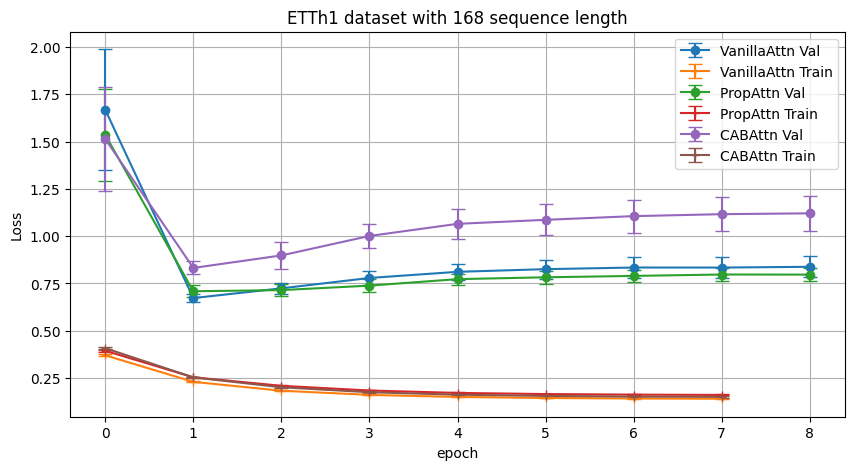

In [30]:
plot_with_std(train_loss_means, train_loss_stds, val_loss_means, val_loss_stds, labels=['VanillaAttn', 'PropAttn', 'CABAttn'], title=f"{kwargs['data']} dataset with {kwargs['seq_len']} sequence length")

log = dict(train_loss_means=train_loss_means, train_loss_stds=train_loss_stds, val_loss_means=val_loss_means, val_loss_stds=val_loss_stds)

np.save(f"stats/{kwargs['data']}", log)
    

In [ ]:
kwargs["epochs"] = 8
kwargs["data"] = "ETTh2"
kwargs["data_path"] = "ETTh2.csv"

train_loss_means, train_loss_stds, val_loss_means, val_loss_stds = [], [], [], []

kwargs["attn"] = "full"
kwargs["n_corr_heads"] = 0
train_loss_mean, train_loss_std, val_loss_mean, val_loss_std = compute_losses(**kwargs)
train_loss_means.append(train_loss_mean); train_loss_stds.append(train_loss_std); val_loss_means.append(val_loss_mean); val_loss_stds.append(val_loss_std)

kwargs["attn"] = "prob"
kwargs["n_corr_heads"] = 0
train_loss_mean, train_loss_std, val_loss_mean, val_loss_std = compute_losses(**kwargs)
train_loss_means.append(train_loss_mean); train_loss_stds.append(train_loss_std); val_loss_means.append(val_loss_mean); val_loss_stds.append(val_loss_std)

kwargs["attn"] = "full"
kwargs["n_corr_heads"] = 8
train_loss_mean, train_loss_std, val_loss_mean, val_loss_std = compute_losses(**kwargs)
train_loss_means.append(train_loss_mean); train_loss_stds.append(train_loss_std); val_loss_means.append(val_loss_mean); val_loss_stds.append(val_loss_std)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

In [ ]:
plot_with_std(train_loss_means, train_loss_stds, val_loss_means, val_loss_stds, labels=['VanillaAttn', 'PropAttn', 'CABAttn'], title=f"{kwargs['data']} dataset with {kwargs['seq_len']} sequence length")

log = dict(train_loss_means=train_loss_means, train_loss_stds=train_loss_stds, val_loss_means=val_loss_means, val_loss_stds=val_loss_stds)

np.save(f"stats/{kwargs['data']}", log)
    

In [ ]:
kwargs["epochs"] = 8
kwargs["data"] = "ETTm1"
kwargs["data_path"] = "ETTm1.csv"

train_loss_means, train_loss_stds, val_loss_means, val_loss_stds = [], [], [], []

kwargs["attn"] = "full"
kwargs["n_corr_heads"] = 0
train_loss_mean, train_loss_std, val_loss_mean, val_loss_std = compute_losses(**kwargs)
train_loss_means.append(train_loss_mean); train_loss_stds.append(train_loss_std); val_loss_means.append(val_loss_mean); val_loss_stds.append(val_loss_std)

kwargs["attn"] = "prob"
kwargs["n_corr_heads"] = 0
train_loss_mean, train_loss_std, val_loss_mean, val_loss_std = compute_losses(**kwargs)
train_loss_means.append(train_loss_mean); train_loss_stds.append(train_loss_std); val_loss_means.append(val_loss_mean); val_loss_stds.append(val_loss_std)

kwargs["attn"] = "full"
kwargs["n_corr_heads"] = 8
train_loss_mean, train_loss_std, val_loss_mean, val_loss_std = compute_losses(**kwargs)
train_loss_means.append(train_loss_mean); train_loss_stds.append(train_loss_std); val_loss_means.append(val_loss_mean); val_loss_stds.append(val_loss_std)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | TransformerCABStack | 29.7 M
1 | loss_function | MSELoss             | 0     
------------------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.887   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

In [ ]:
plot_with_std(train_loss_means, train_loss_stds, val_loss_means, val_loss_stds, labels=['VanillaAttn', 'PropAttn', 'CABAttn'], title=f"{kwargs['data']} dataset with {kwargs['seq_len']} sequence length")

log = dict(train_loss_means=train_loss_means, train_loss_stds=train_loss_stds, val_loss_means=val_loss_means, val_loss_stds=val_loss_stds)

np.save(f"stats/{kwargs['data']}", log)
    

In [ ]:
kwargs["epochs"] = 8
kwargs["data"] = "ETTm2"
kwargs["data_path"] = "ETTm2.csv"

train_loss_means, train_loss_stds, val_loss_means, val_loss_stds = [], [], [], []

kwargs["attn"] = "full"
kwargs["n_corr_heads"] = 0
train_loss_mean, train_loss_std, val_loss_mean, val_loss_std = compute_losses(**kwargs)
train_loss_means.append(train_loss_mean); train_loss_stds.append(train_loss_std); val_loss_means.append(val_loss_mean); val_loss_stds.append(val_loss_std)

kwargs["attn"] = "prob"
kwargs["n_corr_heads"] = 0
train_loss_mean, train_loss_std, val_loss_mean, val_loss_std = compute_losses(**kwargs)
train_loss_means.append(train_loss_mean); train_loss_stds.append(train_loss_std); val_loss_means.append(val_loss_mean); val_loss_stds.append(val_loss_std)

kwargs["attn"] = "full"
kwargs["n_corr_heads"] = 8
train_loss_mean, train_loss_std, val_loss_mean, val_loss_std = compute_losses(**kwargs)
train_loss_means.append(train_loss_mean); train_loss_stds.append(train_loss_std); val_loss_means.append(val_loss_mean); val_loss_stds.append(val_loss_std)


In [ ]:
plot_with_std(train_loss_means, train_loss_stds, val_loss_means, val_loss_stds, labels=['VanillaAttn', 'PropAttn', 'CABAttn'], title=f"{kwargs['data']} dataset with {kwargs['seq_len']} sequence length")

log = dict(train_loss_means=train_loss_means, train_loss_stds=train_loss_stds, val_loss_means=val_loss_means, val_loss_stds=val_loss_stds)

np.save(f"stats/{kwargs['data']}", log)
    

In [ ]:
kwargs["epochs"] = 8

for model_name in ["full_attn", "prob_attn", "corr_attn"]:
    for mr in [0.0, 0.125, 0.25, 0.375, 0.5]:
        for ds_name in ["ETTh1", "ETTh2", "ETTm1", "ETTm2"]:
            
            kwargs["train_masking_ratio"] = mr
            kwargs["attn"] = model_name.split('_')[0]
            kwargs["n_corr_heads"] = 8 if 'corr' in kwargs["attn"] else 0
            kwargs["data"] = ds_name
            kwargs["data_path"] = ds_name + '.csv'

            accelerator = 'gpu' if kwargs["use_gpu"] else 'cpu'

            early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
                monitor='val_loss',
                min_delta=0.00,
                patience=3,
                verbose=True,
                mode="min",
            )



    
            trainer = pl.Trainer(
                max_epochs=kwargs["epochs"],
                devices='auto',
                accelerator=accelerator,
                benchmark=True,
                check_val_every_n_epoch=1,
                callbacks=[early_stop_callback],
                
            )
            
            model = build_model(**kwargs)
            interval_model = IntervalModel(model, **kwargs)
            trainer.fit(interval_model)
            
            postfix = f'{int(100*mr)}_{int(10*(100*mr - int(100*mr)))}'
            torch.save(interval_model.model.state_dict(), f"model_pt/{ds_name}_{model_name}_params_miss_{postfix}.pt")
            

In [ ]:
def test(model_name, ds_name, **kwargs):
    metrics = dict()
    miss_rate = [0.0, 0.125, 0.25, 0.375, 0.5]
    
        
    for i in range(len(miss_rate)):

        kwargs["attn"] = model_name.split('_')[0]
        kwargs["n_corr_heads"] = 8 if 'corr' in kwargs["attn"] else 0
        kwargs["data"] = ds_name
        kwargs["data_path"] = ds_name + '.csv'
        
        postfix = f'{int(100*miss_rate[i])}_{int(10*(100*miss_rate[i] - int(100*miss_rate[i])))}'

        accelerator = 'gpu' if kwargs["use_gpu"] else 'cpu'
        trainer = pl.Trainer(
            max_epochs=kwargs["epochs"],
            devices='auto',
            accelerator=accelerator,
            check_val_every_n_epoch=1,
            
        )
        
        model = build_model(**kwargs)
        params = torch.load(f"model_pt/{ds_name}_{model_name}_params_miss_{postfix}.pt")
        model.load_state_dict(params)
        
        metrics[f"on_train_miss_{miss_rate[i]}"] = dict()
        for j in range(len(miss_rate)):
            kwargs["test_masking_ratio"] = miss_rate[j]
            
            interval_model = IntervalModel(model, **kwargs)
            
            maes = []
            mses = []
            
            for _ in range(10):
                trainer.test(interval_model, verbose=False)
                mae, mse = trainer.callback_metrics["test_mae"], trainer.callback_metrics["test_mse"]
                maes.append(mae)
                mses.append(mse)
            metrics[f"on_train_miss_{miss_rate[i]}"][f"on_test_miss_{miss_rate[j]}"] = [('MAE', [np.mean(maes), np.std(maes)]), ('MSE', [np.mean(mses), np.std(mses)])]
    return metrics


def compile_table(model_name, ds_name, metrics):
    
    mse = [[f"{ds_name}_{model_name}_MSE","on_test_miss_0.0","on_test_miss_0.125","on_test_miss_0.25","on_test_miss_0.375","on_test_miss_0.5"]]
    mae = [[f"{ds_name}_{model_name}_MAE","on_test_miss_0.0","on_test_miss_0.125","on_test_miss_0.25","on_test_miss_0.375","on_test_miss_0.5"]]
    for k, v in metrics.items():
        mse.append([f"{k}"])
        mae.append([f"{k}"])
        for kk, vv in v.items():
            mae[-1].append(f"{vv[0][1][0]:.3f} ± {vv[0][1][1]:.3f}")
            mse[-1].append(f"{vv[1][1][0]:.3f} ± {vv[1][1][1]:.3f}")
    
    mae = pd.DataFrame(mae)
    mse = pd.DataFrame(mse)
    
    mse.to_csv(f"stats/{ds_name}_{model_name}_mse_on_irregular_data.csv")
    mae.to_csv(f"stats/{ds_name}_{model_name}_mae_on_irregular_data.csv")


def plot_model_metrics_with_std(means, stds, model_name):
    plt.title(model_name)
    x = [0.0, 12.5, 25.0, 37.5, 50.0]
    for mean, std, label in zip(means, stds, [f'Train Miss Level {p:.1%}' for p in [0.0, 0.125, 0.25, 0.375, 0.5]]):
        plt.errorbar(x, mean, yerr=std, label=label, fmt='-o', capsize=5)
    plt.xlabel('Test Missing Data Level, %')
    plt.ylabel('Metric Score')
    plt.legend()

def plot_dataset_models_with_std(all_data, all_stds, model_names, dataset_name):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    fig.suptitle(dataset_name)
    
    for ax, data, stds, name in zip(axes, all_data, all_stds, model_names):
        plt.sca(ax)
        plot_model_metrics_with_std(data, stds, name)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
    plt.savefig(f'png/{dataset_name}.png', bbox_inches='tight')
    plt.show()



In [ ]:
def data_collection():

    data_mae = []
    data_mse = []
    
    for ds_name in ["ETTh1", "ETTh2", "ETTm1", "ETTm2"]:
        
        mean_maes = []
        std_maes  = []
        mean_mses = []
        std_mses  = []
        
        for model_name in ["full_attn", "prob_attn", "corr_attn"]:
            
            metrics = test(model_name, ds_name, **kwargs)
            compile_table(model_name, ds_name, metrics)
            
            mean_mae = []
            std_mae  = []
            mean_mse = []
            std_mse  = []
            
            for k, v in metrics.items():
                mean_mae.append([])
                std_mae.append([])
                mean_mse.append([])
                std_mse.append([])
                
                for kk, vv in v.items():
                    mean_mae[-1].append(vv[0][1][0])
                    std_mae[-1].append(vv[0][1][1])
                    mean_mse[-1].append(vv[1][1][0])
                    std_mse[-1].append(vv[1][1][1])
                    
            mean_mae = np.array(mean_mae)
            std_mae = np.array(std_mae)
            mean_mse = np.array(mean_mse)
            std_mse = np.array(std_mse)

            mean_maes.append(mean_mae)
            std_maes.append(std_mae)
            mean_mses.append(mean_mse)
            std_mses.append(std_mse)

        mean_maes = np.stack(mean_maes)
        mean_maes = np.stack(std_maes)
        mean_mses = np.stack(mean_mses)
        std_mses = np.stack(std_mses)

        data_mae.append((ds_name+'_mae', mean_maes, std_maes))
        data_mse.append((ds_name+'_mse', mean_mses, std_mses))

    return data_mae, data_mse

data_mae, data_mse = data_collection()


In [ ]:
model_names = ["full_attn", "prob_attn", "corr_attn"]
for dataset_name, means, stds in data_mae:
    plot_dataset_models_with_std(means, stds, model_names, dataset_name)
    

In [ ]:
model_names = ["full_attn", "prob_attn", "corr_attn"]
for dataset_name, means, stds in data_mse:
    plot_dataset_models_with_std(means, stds, model_names, dataset_name)
    

In [ ]:
np.save("stats/mae_metric_log", data_mae)
np.save("stats/mse_metric_log", data_mse)